# TopoCluster Regression Model Comparison Between DNN and MDN

Here, we are going to write out our topo-cluster regression notebook. Let's start with charged pions, and see what we can do to understand them.

## Setup and Load Data

In [1]:
# ML fitting/loading/saving settings

loadModel = True # if false, then run trainings directly. otherwise load the file.
saveModel = False # if true, save the current model to disk.

from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip util.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  util.zip
replace util/event_util.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!pip install atlas_mpl_style
!pip install uproot3

     |████████████████████████████████| 122kB 6.7MB/s 
     |████████████████████████████████| 92kB 4.8MB/s 


In [4]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
plotpath = './'
modelpath_c = './'
modelpath = './'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [5]:
# import our resolution utilities

import sys
sys.path.append('/content/drive/Shareddrives/UWEPEML/ML4Pion/v7/')
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

/usr/local/lib/python3.7/dist-packages/atlas_mpl_style/__init__.py:164: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  "No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False"


In [6]:
# import pi+

path = '/content/drive/Shareddrives/UWEPEML/ML4Pion/v7/'
pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pp_tree.pandas.df(branches, flatten=False)
#unused: 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'runNumber', 'eventNumber', 

print("Number of pi+ events: {}".format(len(pp)))

Number of pi+ events: 435967


In [7]:
#define convenience columns

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT

In [8]:
# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

In [9]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))


In [10]:
# fun cleaning for EMProb
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [11]:
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)

In [12]:
scaler_EM = StandardScaler()
pp['s_logEM'] = scaler_EM.fit_transform(pp.cluster_logEM.to_numpy().reshape(-1,1))

In [13]:
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))

In [14]:
pp['logCenter'] = np.log(pp.cluster_CENTER_MAG)
scaler_center = StandardScaler()
pp['s_logCenter'] = scaler_center.fit_transform(pp.logCenter.to_numpy().reshape(-1,1))

In [15]:
scaler_density = StandardScaler()
pp['s_Density'] = scaler_density.fit_transform(pp.cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [16]:
# define convience sub-frames

pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster
mu.splitFrameTVT(pp, trainfrac = 0.7)          # define a train/test fraction of 70/20% (10% for val at this point)

In [17]:
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten


In [18]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp

strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [20]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

# Model Evaluation

## DNN

In [ ]:
def DNN():
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    # create model
    if True:
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=1, activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse', metrics=['mae','mse'])
    return model

In [ ]:
regressor_All = KerasRegressor(build_fn=DNN, batch_size=200, epochs=100, verbose=1)
print(DNN().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
if not loadModel:
    chkpoint = tf.keras.callbacks.ModelCheckpoint('./dnn_regressor.h5', monitor='loss', verbose=1, save_best_only=True)
    # earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, verbose=0, restore_best_weights=True)
    history_baseline_all = regressor_All.fit(All_input[pp.train], 
                                             pp[pp.train].s_logECalib.to_numpy(),
                                            #  validation_split=0.1,
                                             callbacks=[chkpoint])
else:
    regressor_All.model = load_model(modelpath + 'dnn_regressor.h5')

In [ ]:
if saveModel:
    regressor_All.model.save(modelpath + 'DNN.h5')

In [ ]:
pred = regressor_All.predict(All_input)
pp['predict_regressor_DNN'] = np.exp(scaler_cal.inverse_transform(pred))
pp['predict_regressor_DNN_EoverCalib'] = pp.predict_regressor_DNN / pp.cluster_ENG_CALIB_TOT

2180/2180 [==============================] - 7s 2ms/step


No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


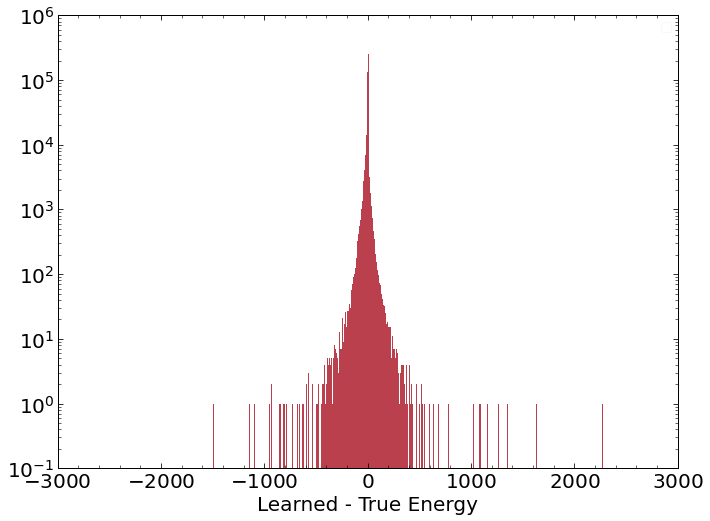

In [ ]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp.predict_regressor_DNN-pp.cluster_ENG_CALIB_TOT,bins = n_bins,alpha=0.75)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-3000,3000)
plt.legend()
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

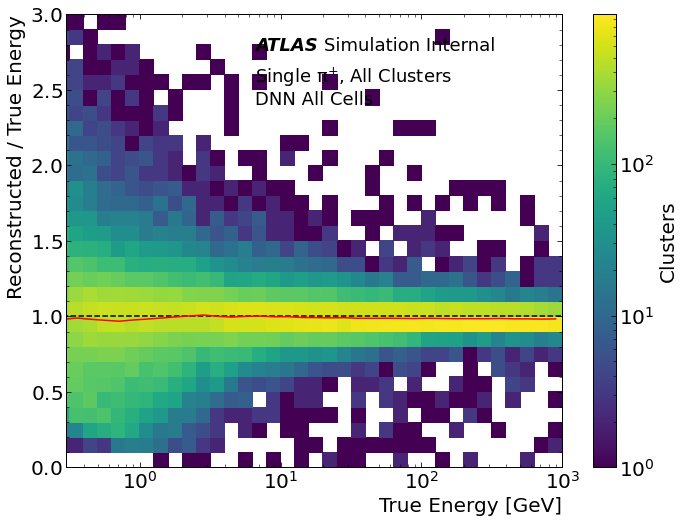

In [ ]:
xcenter, medRegDNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DNN All Cells'}])

<Figure size 799.992x599.976 with 0 Axes>

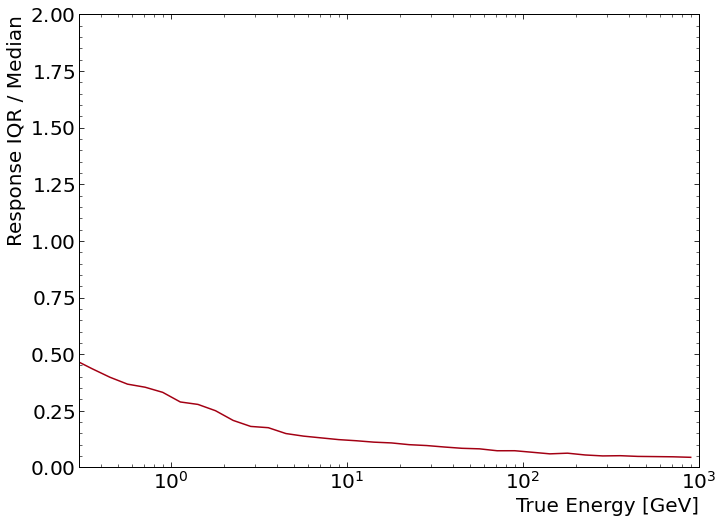

In [ ]:
xcenter, iqrOverMedDNN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_DNN_EoverCalib, statistic='iqrOverMed')

## MDN

In [21]:
loadModel=False
saveModel=True

In [22]:
def MDN():
    event_shape = [1]
    num_components = 1
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=None))
        model.add(tfp.layers.MixtureNormal(num_components, event_shape,
                                    convert_to_tensor_fn=lambda X: tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)))
        opt = Adam(learning_rate=1e-6)#, decay=1e-6)
        model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

In [23]:
regressor_All = KerasRegressor(build_fn=MDN, batch_size=100, epochs=100, verbose=1)
print(MDN().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)         

In [25]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('./mdn_regressor.h5', monitor='loss', verbose=1, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, verbose=0, restore_best_weights=True)

loadModel = True
if not loadModel:
    history_baseline_all = regressor_All.fit(All_input[pp.train], 
                                             pp[pp.train].s_logECalib.to_numpy(),
                                            #  validation_split=0.1,
                                             callbacks=[chkpoint, earlystop])
    regressor_All.model.save(modelpath + 'MDN.h5')
else:
    regressor_All = MDN()
    regressor_All.load_weights(modelpath + 'mdn_regressor.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [27]:
pred = regressor_All.predict(All_input)
pp['predict_regressor_MDN'] = np.exp(scaler_cal.inverse_transform(pred[:,0]))
pp['predict_regressor_MDN_EoverCalib'] = pp.predict_regressor_MDN / pp.cluster_ENG_CALIB_TOT

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


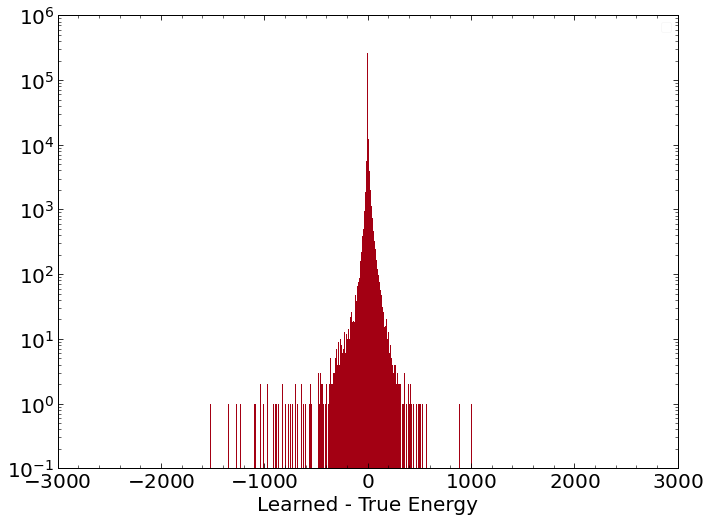

In [28]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp.predict_regressor_MDN-pp.cluster_ENG_CALIB_TOT,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-3000,3000)
plt.legend()
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

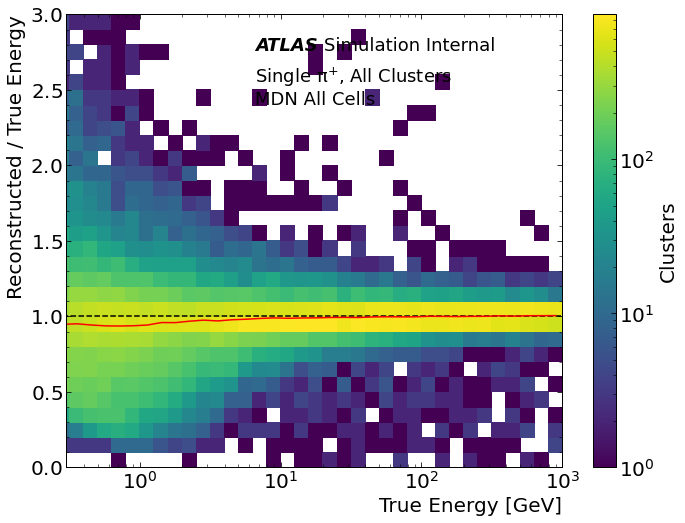

In [29]:
xcenter, medRegMDN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN All Cells'}])

<Figure size 799.992x599.976 with 0 Axes>

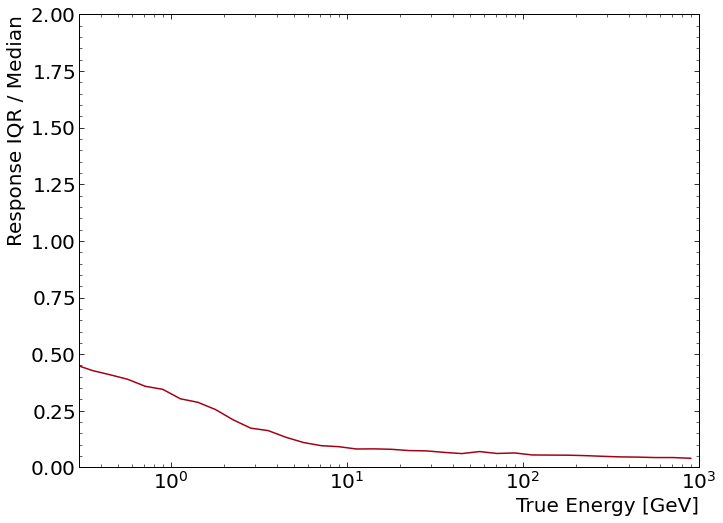

In [30]:
xcenter, iqrOverMedMDN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_MDN_EoverCalib, statistic='iqrOverMed')

## Results Overlayed

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

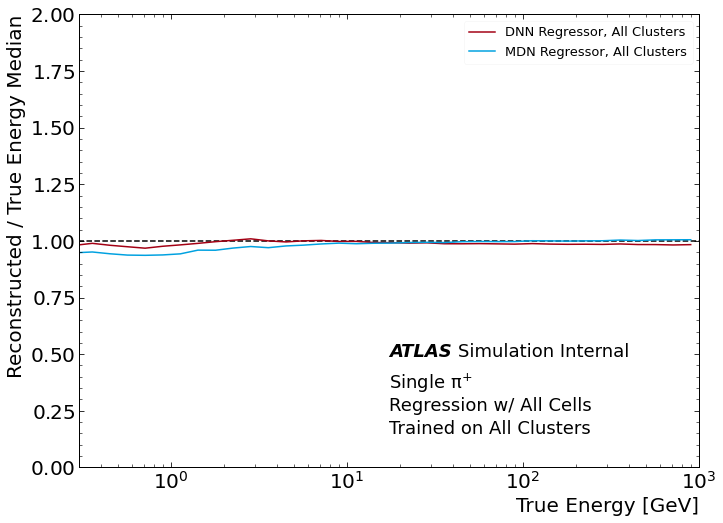

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [medRegDNN, medRegMDN],
                                labels = ['DNN Regressor, All Clusters', 'MDN Regressor, All Clusters'],
                xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy Median',
                figfile = plotpath + "hist_2D_E_vs_ratio_pp_profile_Overlay_Overlay_BaseLCAll.pdf",
                x_min = 0.3, y_max = 2.0,
                extra_lines = [[[0.1,1000],[1,1]]],
                # linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.5, atlas_y = 0.275, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.175, 'text': 'Single $\pi^{+}$'},
                                  {'x': 0.5, 'y': 0.125,  'text': 'Regression w/ All Cells'},
                                  {'x': 0.5, 'y': 0.075, 'text': 'Trained on All Clusters'}])

<Figure size 799.992x599.976 with 0 Axes>

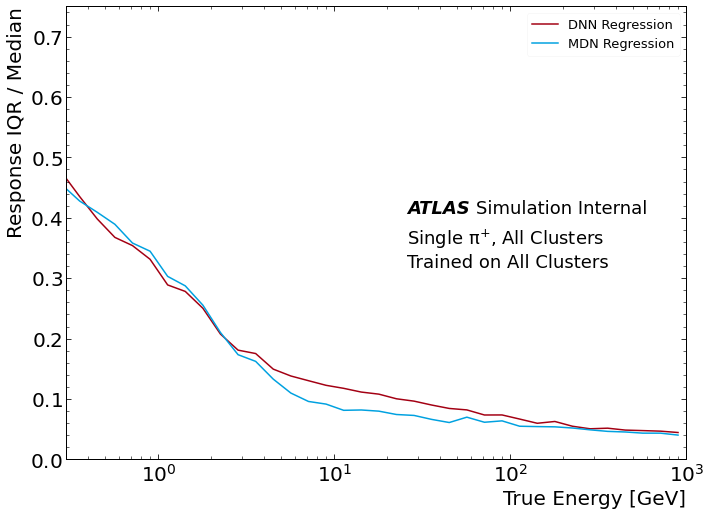

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedDNN, iqrOverMedMDN],
                labels = ['DNN Regression', 'MDN Regression'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = 0.75,
                # linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.55, atlas_y = 0.575, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.475, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.55, 'y': 0.425, 'text': 'Trained on All Clusters'}])

<Figure size 799.992x599.976 with 0 Axes>

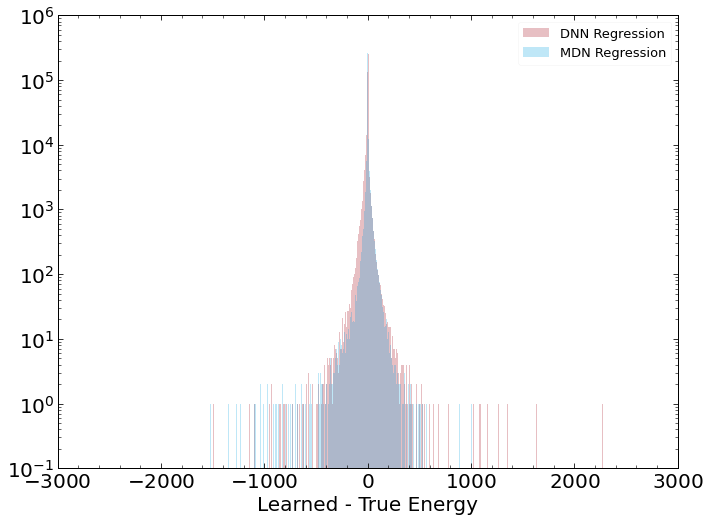

In [ ]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp.predict_regressor_DNN-pp.cluster_ENG_CALIB_TOT,bins = n_bins,alpha=0.25, label='DNN Regression')
plt.hist(pp.predict_regressor_MDN-pp.cluster_ENG_CALIB_TOT,bins = n_bins,alpha=0.25, label='MDN Regression')
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-3000,3000)
plt.legend()
plt.show()

## Now a way to visualize per cluster uncertainty

In [ ]:
median = pred[:,0]
sigma = pred[:,1]

In [ ]:
iqr = 2*0.67448*sigma

In [ ]:
test = pd.Series(iqr)

In [ ]:
test.rolling(window=100).mean()

99        0.094452
100       0.095952
101       0.096350
102       0.094722
103       0.095395
            ...   
435962    0.102769
435963    0.102957
435964    0.103023
435965    0.102841
435966    0.104603
Length: 435868, dtype: float64

(0.0, 2.0)

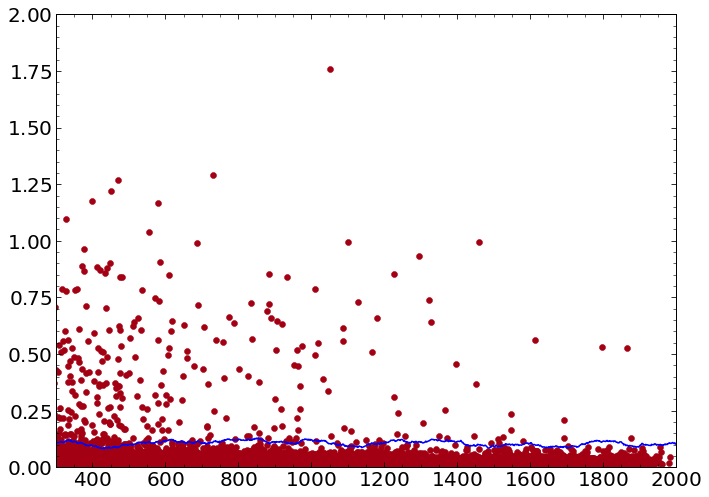

In [ ]:
plt.scatter(pp.cluster_ENG_CALIB_TOT,iqr)
plt.plot(test.rolling(window=100).mean(), 'b')
plt.xlim(300,2000)
plt.ylim(0,2)

<Figure size 799.992x599.976 with 0 Axes>

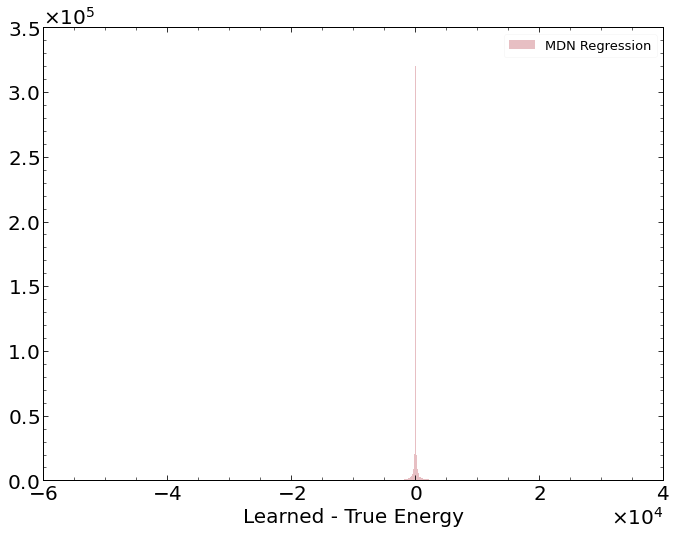

In [ ]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# plt.hist(pp.predict_regressor_DNN-pp.cluster_ENG_CALIB_TOT,bins = n_bins,alpha=0.25, label='DNN Regression')
plt.hist((pp.predict_regressor_MDN-pp.cluster_ENG_CALIB_TOT) / pred[:,1],bins = n_bins,alpha=0.25, label='MDN Regression')
# plt.yscale('log')
plt.xlabel('Learned - True Energy')
# plt.xlim(-3000,3000)
plt.legend()
plt.show()